# CE7454 Project - Group 05

Lu Yuhao, Xue Chuhui, Wu Rongliang, Zhan Fangneng


## Part I. Project Description

Generative Adversarial Networks (GANs) has attracted increasing attention in recent years due to its significant performances on image generation task. In general, sample images are generated by a generator, then both input images and generated images are passed into a discriminator which decides if a image is real or generated. During this process, the generator tries to generate images that are hard for discriminator to judge, and discriminator tries to guide the generator to produce more realistic images. In this project, we will focus on some recent advanced architectures of GANs, like CycleGAN, StarGAN. The goal of this project is to generate cartoon (anime) faces for real faces.


## Part II. Data Acquisition

Real faces:
CelebA dataset: details in http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

Anime faces:
As we did not find any datasets that contains faces of anime characters, we need to create a datset by ourselves.

After looking through famous websites that have anime images, we decide to download anime images from http://konachan.net/

In [2]:
import os
import requests
from bs4 import BeautifulSoup

Define download function which is to download image and save to corresponding path (details in src/image_downloader.py)

In [2]:
from src import image_downloader

Create folder for saving images if it does not exist

In [3]:
if os.path.exists('data/anime/imgs') is False:
    os.makedirs('data/anime/imgs')

Indicate range of website index (on http://konachan.net/)
Note that each multiple images will be downloaded on one page

In [4]:
start = 1
end = 3

Download image and save under folder 'imgs'

In [5]:
for i in range(start, end + 1):
    url = 'http://konachan.net/post?page={}&tags='.format(i)
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')
    for img in soup.find_all('img', class_="preview"):
        target_url = img['src']
        filename = os.path.join('data/anime/imgs', target_url.split('/')[-1])
        image_downloader.download(target_url, filename)
        
    print('{} / {}'.format(i, end))

1 / 3
2 / 3
3 / 3


## Part III. Data Exploration

We visualize several downloaded images from anime image website.

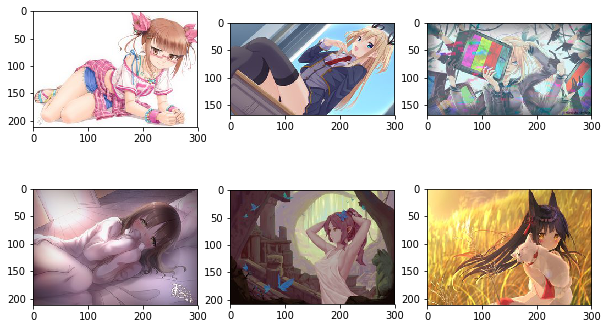

In [11]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

file_list = glob('data/anime/imgs/*.jpg')
w = 10
h = 10
fig = plt.figure(figsize=(10, 6))
columns = 3
rows = 2
for i in range(1, columns*rows + 1):
    img = mpimg.imread(file_list[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

We could see that most of images contain large amount of background or human bodies that we do not need. Therefore, we need to detect and crop the faces of each character.

## Part IV. Preprocessing

We use a pretrained model provided by http://ultraist.hatenablog.com/entry/20110718/1310965532 and OpenCV function CascadeClassifier for anime face detection. 

Each detected faces will be cropped and saved into folder 'faces'. 

All detected faces with score less than 2 or size less than 48 * 48 will be filtered out. 

Details of face detection and cropping can be found at src/anime_face_detector.py.

In [7]:
from src import anime_face_detector

Create folder for saving cropped faces

In [8]:
if os.path.exists('data/anime/faces') is False:
    os.makedirs('data/anime/faces')

Detect and crop faces from all downloaded images

In [9]:
file_list = glob('data/anime/imgs/*.jpg')
pretrained_model = "data/anime/pretrained_model/lbpcascade_animeface.xml"
for filename in file_list:
    anime_face_detector.detect(filename, pretrained_model)

Visualize cropped faces

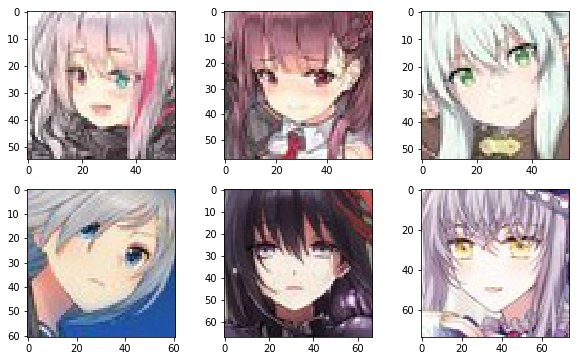

In [10]:
file_list = glob('data/anime/faces/*.jpg')
fig = plt.figure(figsize=(10, 6))
columns = 3
rows = 2
for i in range(1, columns*rows + 1):
    img = mpimg.imread(file_list[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# LYH 's part

In [3]:
cur_dir = os.getcwd()
print(cur_dir)

/home/yuhao/Projects/CE7454_Project_Group_5


### Model 1- A neural algorithm of artistic style

Refer to details in the following notebook:
#####                           end2end_and_artistic_style_transfer/neural_artistic_style/neural_style_transfer.ipynb

In [4]:
os.chdir('end2end_and_artistic_style_transfer/neural_artistic_style/')

%run neural_style_transfer.ipynb

os.chdir(cur_dir)

<Figure size 640x480 with 1 Axes>

1 / 13
2 / 13


KeyboardInterrupt: 

### Model 2- End-to-end neural style transfer

Refer to details in the following notebook: (for training)
#####                           end2end_and_artistic_style_transfer/end2end_neural_style_transfer/pytorch-CycleGAN-and-pix2pixipynb

In [ ]:
os.chdir('end2end_and_artistic_style_transfer/end2end_neural_style_transfer/')

%run stylize.py  ../../trained_models/end2end_cnt1_2.pth ../../data/testA/ ../../outputs/end2end_neural_transfer/   

os.chdir(cur_dir)

### Model 3 - CycleGAN

Refer to details in the following file:
#####           pytorch-CycleGAN-and-pix2pix/models/cycle_gan_model.py

In [ ]:
os.chdir('pytorch-CycleGAN-and-pix2pix/')

%run test.py --dataroot ../data/ --name celeba2comic_origin  --model cycle_gan  --direction AtoB --results_dir ../outputs/cycleGAN

print('end...saved to >> ../outputs/cycleGAN/')
os.chdir(cur_dir)

# WU Rongliang's part

## Part 3. Model

In this part, we will show the quantitative results of our customized cartoon portrait GAN (CPGAN), and compare with the results of StarGAN, CartoonGAN, and basic GAN. Here we refer basic GAN to the network that shares the same architecture with our proposed CPGAN but trained with WGAN-GP only.

## 3.1 Library Loading

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
import numpy as np
import os
import time
import datetime
from glob import glob
from PIL import Image

import sys
sys.path.append("/home/rongliang/CE7454_project/")

from Model_cartoonGAN import generator as Generator_cartoonGAN
from Model_starGAN import Generator as Generator_starGAN
from Model import Generator
from Model_cyc import Generator_cyc
from Perceptual_loss import LossNetwork

from utils import data_load
from utils import print_network
from utils import to_img
from utils import show_im
from utils import gram_matrix

## 3.2 Initialzation

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.empty_cache()

# the location of test data folder
Data_dir = "data/final_test/"

# please download the weights here:
# https://drive.google.com/drive/folders/1b_FXIn5mAfGYKdYw0dJRxOtoqI0IxQ43?usp=sharing
Basic_GAN_model = "Basic_GAN_G_weight.pth"
StarGAN_model = "Star_GAN_G_weight.ckpt"
Cartoon_GAN_model = "CartoonGAN_G_weight.pkl"
CPGAN_G_GAN_model = "CPGAN_G_weight.pth"

# File_name = glob(Data_dir + "/*jpg")

Img_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

C = torch.tensor([[1. ,0.]]).to(device)

with torch.no_grad():
    # basic GAN
    G_basic = Generator()
    G_basic.load_state_dict(torch.load(Basic_GAN_model))
    G_basic = G_basic.to(device)
    G_basic.eval()

    # StarGAN
    G_starGAN = Generator_starGAN(64, 2, 6)
    G_starGAN.load_state_dict(torch.load(StarGAN_model, map_location=lambda storage, loc: storage))
    G_starGAN = G_starGAN.to(device)
    G_starGAN.eval()


    # CartoonGAN
    G_cartoonGAN = Generator_cartoonGAN(in_nc = 3, out_nc = 3, nf=64, nb=8)
    G_cartoonGAN.load_state_dict(torch.load(Cartoon_GAN_model))
    G_cartoonGAN = G_cartoonGAN.to(device)
    G_cartoonGAN.eval()
                                 

    # CPGAN
    CPGAN_G_GAN = Generator_cyc(domain_dim=2)
    CPGAN_G_GAN.load_state_dict(torch.load(G_customized_GAN_model))
    CPGAN_G_GAN = G_customized_GAN.to(device)
    CPGAN_G_GAN.eval()
    
# displaying function
def generate_images(Current_image_path):
    Current_image = Image.open(Current_image_path)
    Current_image = Img_trans(Current_image)
    Current_image = Current_image.to(device)
    Current_image = torch.unsqueeze(Current_image, dim = 0)

    # the result of Basic GAN
    Basic_GAN_output = G_basic(Current_image)

    # the result of StarGAN
    StarGAN_output = G_starGAN(Current_image, C)

    # the result of Cartoon GAN
    Cartoon_GAN_output = G_cartoonGAN(Current_image)

    # the result of our proposed CPGAN
    CPGAN_G_GAN_output = CPGAN_G_GAN(Current_image, C)

    Display_image_list = [Current_image]
    Display_image_list.append(Basic_GAN_output.detach())
    Display_image_list.append(StarGAN_output.detach())
    Display_image_list.append(Cartoon_GAN_output.detach())
    Display_image_list.append(G_customized_GAN_output.detach())
    

    Display_image = torch.cat(Display_image_list, dim = 3)
    Display_image = to_img(Display_image.cpu())
    
    return Display_image

## 3.3 Obtain the Results of each Model

In [3]:
# you can replace with your own image
Current_image_path = '/home/rongliang/CE7454_project/data/final_test/001422.jpg'

Image_0 = generate_images(Current_image_path)

## 3.4 Display the Results

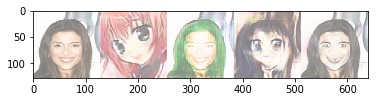

In [4]:
show_im(to_img(Image_0.squeeze(0)))

#### From left to right: Input image, the results of Basic GAN, StarGAN, Cartoon GAN and our proposed CPGAN, respectively.

## 3.5 Discussion
As can be seen from the results above, basic GAN (trained with WGAN-GP only) can output an cartoon image, however, which may have no relations the original input image. Although StarGAN can maintain the attributes of the input image, it fails to convert the original image into a cartoon style image, and the quality of the generated cartoon image of cartoonGAN is poor. With the customized loss functions, our proposed CPGAN can generate the images with best visual quality while preserving most of the details of the original images.

## 3.6 More results

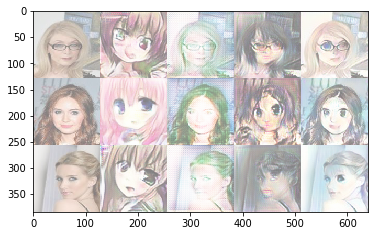

In [11]:
Current_image_path_1 = 'data/002058.jpg'
Current_image_path_2 = 'data/000085.jpg'
Current_image_path_3 = 'data/004095.jpg'

Image1 = generate_images(Current_image_path_1)
Image2 = generate_images(Current_image_path_2)
Image3 = generate_images(Current_image_path_3)

Display_image_all = torch.cat([Image1, Image2, Image3], dim = 2)

show_im(to_img(Display_image_all.squeeze(0)))

# save_image(to_img(Display_image_all.squeeze(0)), "outputs/2.bmp")

## Part 4. Evaluation

We evaluate the performance of GANs in three methods:
1. A classifitcation task to evaluate the quality of synthesized images by GANs.
2. AMT user study to evaluate the realism of generated images.
3. Tranlation samples.

### Classification Task
Train classification model to distinguish a image is Japanese style or American style. Trained on synthesized Japanese cartoon https://drive.google.com/open?id=1TNCrz8ptaPkvgwu4yYeKzas8t-eRv9TW and real American Cartoon iiit-cfw https://cvit.iiit.ac.in/research/projects/cvit-projects/cartoonfaces, test on real Japanese cartoon https://drive.google.com/open?id=1HBpvigbvttOBOyE-w-xNr6BjdqyRoJCr.

Trian classification model

In [1]:
import os
import numpy as np
import tensorflow as tf
from evaluation import model
from evaluation import input_data

N_CLASSES = 2
IMG_W = 208  # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
BATCH_SIZE = 16
CAPACITY = 2000
MAX_STEP = 10 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001

Get training data

In [2]:
train, train_label = input_data.get_files()
train_batch, train_label_batch = input_data.get_batch(train,
                                                      train_label,
                                                      IMG_W,
                                                      IMG_H,
                                                      BATCH_SIZE,
                                                      CAPACITY)

There are 3 japanese cartoon 
There are 3 american cartoon


Get the model

In [3]:
train_logits = model.inference(train_batch, BATCH_SIZE, N_CLASSES)
train_loss = model.losses(train_logits, train_label_batch)
train_op = model.trainning(train_loss, learning_rate)
train__acc = model.evaluation(train_logits, train_label_batch)

Train the model

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

for step in np.arange(0):
    if coord.should_stop():
            break
    _, tra_loss, tra_acc = sess.run([train_op, train_loss, train__acc])

Get the test data

In [5]:
test, test_label = input_data.get_files()
test_batch, test_label_batch = input_data.get_batch(test,
                                                    test_label,
                                                    IMG_W,
                                                    IMG_H,
                                                    BATCH_SIZE,
                                                    CAPACITY)
testcorr = model.test_evaluation(train_logits, test_label_batch)

There are 3 japanese cartoon 
There are 3 american cartoon


Get the test result

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

for step in np.arange(0):
    if coord.should_stop():
            break
    test_acc = sess.run(testcorr)
print ('test accuracy')

0.5


End